# Отчет о проекте «Идентификация интернет-пользователей»

## Kaggle-соревнование "Identify me if you can"
\- I can in 67% of cases


Сам ноутбук можно найти здесь: https://github.com/ashatilov/Identify-me-if-you-can

# Цели и задачи проекта

В этом проекте решается задача идентификации пользователя по нескольким посещенным им подряд сайтам - сессии пользователя.

Пользователей всего 550, данные собраны с прокси-серверов Университета Блеза Паскаля.

Сырые данные train имеют очень простой вид: для каждого пользователя csv файл с информацией о времени посещения сайта и веб-сайте

Тестовые данные уже собраны в пользовательские сессии с информацией о сайте и времени его посещения.  
Длина сессии - до 10 сайтов с ограничением в 30 минут.  
Всего имеется 41177 тестовых сессии.

**Цель** - верно разметить принадлежность тестовых сессий пользователям  
**Целевая метрика** – доля правильных ответов (categorization accuracy).

# Предварительная подготовка данных

Сырые данные можно разбить на сессии разной длины с разной длиной окна и ограничением по времени. Но т.к. тестовые данные у нас уже собраны в сессии длиной 10 и ограничением 30 минут, то в последующем мы можем только изменять длину окна для подготовки данных, получая при этом разное количество train сессий.

#### Необходимые импорты

In [1]:
import numpy as np
import pandas as pd
import os
import re
import pickle

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from matplotlib import pyplot as plt
import seaborn as sns
import plotly.plotly as py
import plotly.graph_objs as go
%matplotlib inline

#### Код подготовки данных train

In [2]:
def prepare_train(session_length=10, window_size=10, time_limit=30):
    # прочитаем все файлы из папки /train в один dataframe
    if os.path.isfile('train_raw.pkl'):
        with open('train_raw.pkl', 'rb') as f:
            df = pickle.load(f)
    else:
        files = ['train/' + file for file in os.listdir('train/') if file.endswith('.csv')]
        user_dfs = []
        for file in files:
            tmp = pd.read_csv(file, parse_dates=['timestamp'])
            tmp['user_id'] = int(re.search('\d+', file).group())
            tmp = tmp.sort_values('timestamp')
            user_dfs.append(tmp)
        df = pd.concat(user_dfs)
            
        # добавим id сайта, используя уже готовый словарь, который идет вместе с данными
        with open('site_dictionary.pkl', 'rb') as f:
            sites_dict = pickle.load(f)
        df['site_id'] = [sites_dict[site_name] for site_name in df['site']]

        # сохраним данные в файл
        with open('train_raw.pkl', 'wb') as f:
            pickle.dump(df, f)
      
    # преобразование для нужного window_size
    # создадим пустую матрицу сессий и вектор ответов - id пользователей
    matrix_sites = np.empty((1, session_length), dtype='int32')
    matrix_times = np.empty((1, session_length), dtype='datetime64[s]')
    y = np.empty((1,), dtype=np.int32)

    # соберем матрицу и вектор ответов по всем пользователям
    for user_id in df.user_id.unique():
        # рассмотрим вектор из id сайтов для каждого юзера
        vect = df.loc[df['user_id'] == user_id].sort_values('timestamp')
        vect_sites = vect['site_id'].values
        vect_times = vect['timestamp'].values.astype('datetime64[s]')

        # составим из него матрицу соответствующей длины сессии и длины окна
        l = len(vect)            
        tmp_sites = np.vstack([np.hstack([vect_sites[i:i+session_length],
                                          np.repeat(0, 0 if (i + session_length) <= l
                                                    else session_length - (l - i))])
                               for i in range(l)[::window_size]])

        tmp_times = np.vstack([np.hstack([vect_times[i:i+session_length],
                                          np.repeat(np.datetime64('NaT'), 0 if (i + session_length) <= l
                                                    else session_length - (l - i))])
                               for i in range(l)[::window_size]])
        
        # соединим с общей матрицей
        matrix_sites = np.vstack((matrix_sites, tmp_sites))
        matrix_times = np.vstack((matrix_times, tmp_times))

        # соединим вектор одного юзера с общим вектором ответов
        y_user = np.full((tmp_sites.shape[0],), user_id, dtype=np.int32)
        y = np.append(y, y_user)

    # избавимся от ненужных начальных значений, полученных при создании матрицы и вектора
    y = y[1:]  
    matrix_sites = matrix_sites[1:,:]
    matrix_times = matrix_times[1:,:]

    # соберем вместе данные по сайтам и временам
    df_sessions = pd.concat([pd.DataFrame(matrix_sites, dtype='int32'),
                             pd.DataFrame(matrix_times, dtype='datetime64[s]'),
                             pd.DataFrame(y)],
                            axis=1, ignore_index=True)
    # назовем столбцы
    df_sessions.columns = (['site' + str(i) for i in range(1, session_length + 1)] +
                           ['time' + str(i) for i in range(1, session_length + 1)] +
                           ['user_id'])
    df_sessions.index.name = 'session_id'
    
    if time_limit:
    # обнулим сайты и времена, которые выходят за длину сессии в 30 минут (или другое значение)
        for i in range(10, 1, -1):
            tmp = df_sessions['time' + str(i)] - df_sessions['time1']
            indices_to_null = np.where(tmp > np.timedelta64(time_limit,'m'))[0]
            df_sessions = df_sessions.set_value(indices_to_null, 'site' + str(i), 0)
            df_sessions = df_sessions.set_value(indices_to_null, 'time' + str(i), np.datetime64('NaT'))
    
    return df_sessions

#### Код подготовки данных test

In [3]:
def prepare_test():
    name = 'test_sessions.pkl'
    if os.path.isfile(name):
        with open(name, 'rb') as f:
            test_df = pickle.load(f)
    else:
        test_df = pd.read_csv('test_sessions.csv', index_col='session_id')
        test_sites = test_df[['site' + str(i) for i in range(1, 11)]].fillna(0).astype('int32')
        test_times = test_df[['time' + str(i) for i in range(1, 11)]].fillna(np.datetime64('NaT')).astype('datetime64[s]')
        test_df = pd.concat([test_sites, test_times], axis=1)
        test_df['user_id'] = -1
        with open(name, 'wb') as f:
                pickle.dump(test_df, f)
    return test_df

### Результат подготовки

Подготовим предварительные датасеты с разной шириной окна:

In [4]:
%%time
# создадим предварительные датасеты для разной ширины окна
!mkdir pre_datasets
for window_size in range(1, 11):
    name = 'pre_datasets/train_w' + str(window_size) + '.pkl'
    if os.path.isfile(name):
        continue
    else:
        tmp = prepare_train(window_size=window_size)
        with open(name, 'wb') as f:
            pickle.dump(tmp, f)

CPU times: user 2min 54s, sys: 4.94 s, total: 2min 59s
Wall time: 3min 1s


Предварительные датасеты имеют следующий вид:

In [5]:
tmp.head(3)

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,...,time2,time3,time4,time5,time6,time7,time8,time9,time10,user_id
session_id,,,,,,,,,,,,,,,,,,,,,
0,15,23,2,2,2,2,9,21,9,8,...,2013-06-12 10:22:56,2013-06-12 10:23:24,2013-06-12 10:23:25,2013-06-12 10:23:39,2013-06-12 10:24:34,2013-06-12 10:26:39,2013-06-12 10:26:39,2013-06-12 10:26:40,2013-06-12 10:33:23,1005
1,32,24,8,24,8,4,12,5,28,1,...,2013-06-12 10:33:32,2013-06-12 10:33:32,2013-06-12 10:33:33,2013-06-12 10:33:33,2013-06-12 10:33:33,2013-06-12 10:33:34,2013-06-12 10:33:35,2013-06-12 10:33:35,2013-06-12 10:33:44,1005
2,4,26,1,1,8,1,41,12,1,1,...,2013-06-12 10:33:45,2013-06-12 10:33:46,2013-06-12 10:33:58,2013-06-12 10:33:59,2013-06-12 10:34:04,2013-06-12 10:34:09,2013-06-12 10:34:10,2013-06-12 10:34:28,2013-06-12 10:34:36,1005


# Создание дополнительных признаков

Во время подготовки проекта было создано довольно много дополнительных признаков, некоторые из которых занимали определенное время для их создания, но не принесли пользы (или просто я не умею их готовить). В финальный отчет я решил их не включать: tfidf посещенных сайтов, домены разных уровней, tfidf для доменов разных уровней, доля посещения конкретного сайта каждым юзером в train относительно всех посещений данного сайта.

Ниже приводится код для создания следующих признаков:
- день недели начала сессии
- час начала сессии
- бинарный признак, показывающий выходной день или нет
- длина сессии в секундах (время последнего сайта - время первого)
- количество уникальных сайтов в сессии
- относительное количество уникальных сайтов в сессии (кол-во уникальных / кол-во сайтов в сессии)
- время нахождения на каждом сайте в сессии (кроме последнего)
- среднее время нахождения на сайте в сессии
- дата сессии до часа с one hot encoding - признак уже содержится во времени захода на первый сайт сессии. Будет добавлен при подготовки данных в vowpal wabbit, т.к. там его можно указать просто: например, '2014-01-25_9'.

#### Код подготовки вспомогательных данных

In [6]:
# загрузим датасет train_raw (созданный в функции prepare_train), который имеет основые столбцы время-сайт-юзер
with open('train_raw.pkl', 'rb') as f:
    train_raw = pickle.load(f)

# заранее объявим списки имен признаков для отдельных сайтов:
# имена столбцов с данными о сайтах и времени посещения
cols_site = ['site' + str(i) for i in range(1, 11)]
cols_time = ['time' + str(i) for i in range(1, 11)]
# имена столбцов с данными о времени пребывания на сайте
cols_diff = ['diff' + str(i) for i in range(1, 10)]

# загрузим готовый словарь с сайтами, который идет вместе с данными
with open('site_dictionary.pkl', 'rb') as f:
    sites_dict = pickle.load(f)
# сделаем из него обратный ему:
sites_dict = dict([(v, k) for k, v in sites_dict.items()])

# создадим словарь с индексами юзеров от 1 до 550, чтобы далее использовать в vowpal wabbit
# 1 - у чаще всего встречающегося и т.д.
us_dict = dict(zip(train_raw.user_id.value_counts().index, range(1, 551)))

# обратный ему словарь, для отправки решения на kaggle
us_dict_inv = dict([(v, k) for k, v in us_dict.items()])

Функция, возвращающая общий датасет (сначала строки train, потом строки test) с новыми признаками и длину валидационного/тестового датасета test_len

#### Код подготовки датасета

In [8]:
def prepare_df(pre_file='pre_datasets/train_w5.pkl', valid=True):    
    with open(pre_file, 'rb') as f:
        df = pickle.load(f)
               
    if valid:
        # разобъем его на train и valid
        df, test_df = train_test_split(df, test_size=0.3, stratify=df.user_id)
    else:
        # если датасет для валидации не нужен, используем test
        test_df = prepare_test()
        
    # соберем train и test вместе
    test_len = test_df.shape[0]
    df = pd.concat([df, test_df])
    
    # добавим признаки промежутков времени
    for name, i, j in zip(['diff' + str(i) for i in range(1, 10)], cols_time[1:], cols_time[:-1]):
        df[name] = (df[i] - df[j]) / np.timedelta64(1,'s')

    # добавим признак длины сессии
    df['session_timespan'] = ((df[cols_time].max(axis=1) - df[cols_time].min(axis=1)) / np.timedelta64(1,'s')).astype(np.int32)

    # добавим признаки часа и дня минимального timestamp в сессии
    df['start_hour'] = df[cols_time].min(axis=1).dt.hour
    df['day_of_week'] = df[cols_time].min(axis=1).dt.dayofweek

    # добавим признаки выходного дня
    df['is_weekend'] = df['day_of_week'].apply(lambda x: x in [5,6]).astype(int)

    # добавим признак количества уникальных сайтов в сессии
    df['unique_sites'] = [len(set(i for i in row if i != 0)) for row in df[cols_site].values]
    df['unique_sites_rel'] = [l / np.count_nonzero(row)
                              for l, row in zip(df.unique_sites, df[cols_site].values)]

    # признаки, связанные со временами нахождения на сайтах в сессии
    # пропуски будут в сессиях с одним сайтом, заполним их нулями
    df['diff_mean'] = df[cols_diff].mean(axis=1).fillna(0)
    df['diff_median'] = df[cols_diff].median(axis=1).fillna(0)
    df['diff_std'] = df[cols_diff].std(axis=1).fillna(0)
    
    return df, test_len

# Визуальный анализ

Подготовим полный датасет со всеми 550 юзерами из предварительных сессий с шириной окна 10, без валидационного датасета, чтобы посмотреть на все имеющиеся в train данные и сравнить их с тестовыми

In [9]:
df, test_len = prepare_df(pre_file='pre_datasets/train_w10.pkl', valid=False)
df_train, df_test = df.iloc[:-test_len, :], df.iloc[-test_len:, :]

#### Код графика распределения длины сессий

In [10]:
def plot_session_timespan():
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    for idx, data, dname, color in zip([0, 1], [df_train, df_test], ['train', 'test'], ['b', 'g']): 
        ax = axes[idx]
        data = data.session_timespan
        ax.hist(data, weights=np.zeros_like(data) + 1. / data.size, label=dname,
               bins=np.arange(0, 1801, 200), color=color, alpha=0.7)
        ax.set_xlabel('Длина сессии, с')
        ax.set_ylabel('Относитительное количество сессий')
        ax.set_ylim(0, 1)
        ax.set_yticks(np.arange(0, 1.1, 0.1))
        ax.legend([dname])
    plt.show()

### График распределения длины сессий

Посмотрим, как распределены продолжительности сессий пользователей в тренировочном и тестовом датасетах

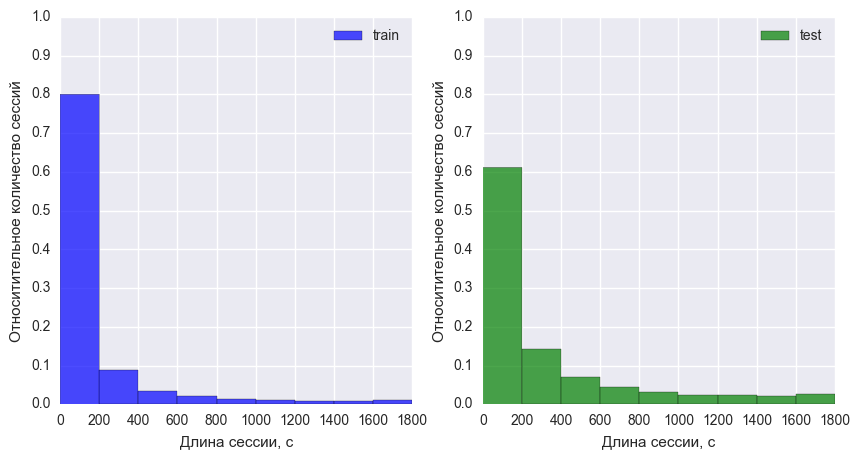

In [11]:
plot_session_timespan()

Как видно, сессии из тестового датасета отличаются по продолжительности - в нем меньше коротких и больше длинных сессий, сессии длиной до 200 секунд составляют около 60% от всех, а не 80%, как в train.

#### Код распределения сессий по часу начала

In [12]:
def plot_start_hour():
    data = pd.DataFrame({'train': df_train.start_hour.value_counts() / df_train.shape[0],
                       'test': df_test.start_hour.value_counts() / df_test.shape[0]})
    data = data[['train', 'test']]
    data['hour'] = data.index
    data = pd.melt(data, id_vars=['hour'])
    ax = sns.barplot(x='hour', y='value', hue='variable', data=data)
    ax.legend(title="Датасет", loc="best")
    ax.set(xlabel='Час начала сессии', ylabel='Относительное число сессий в датасете')
    plt.show()

### График распределения сессий по часу начала

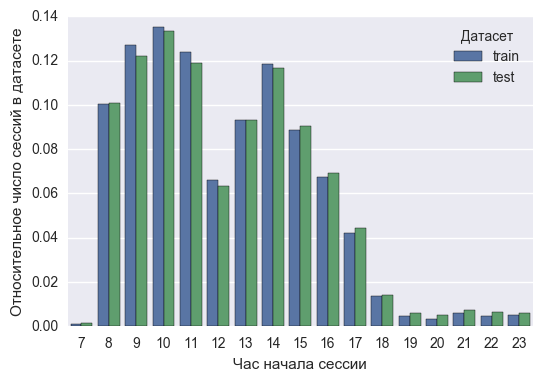

In [13]:
plot_start_hour()

Распределения часа начала сессии в тренировочном и тестовом датасетах очень похожи, почти не отличаются. Больше всего сессий начинается в 10 и 14 часов.

#### Код графика распределения сессий по дням недели

In [14]:
def plot_day_of_week():
    data = pd.DataFrame({'train': df_train.day_of_week.value_counts() / df_train.shape[0],
                       'test': df_test.day_of_week.value_counts() / df_test.shape[0]})
    data = data[['train', 'test']]
    data['day'] = data.index
    data = pd.melt(data, id_vars=['day'])
    ax = sns.barplot(x='day', y='value', hue='variable', data=data)
    ax.legend(title="Датасет", loc="best")
    ax.set(xlabel='День недели сессии', ylabel='Относительное число сессий в датасете')
    plt.xticks(range(7), ['пн', 'вт', 'ср', 'чт', 'пт', 'сб', 'вс'])
    plt.show()

### График распределения сессий по дням недели

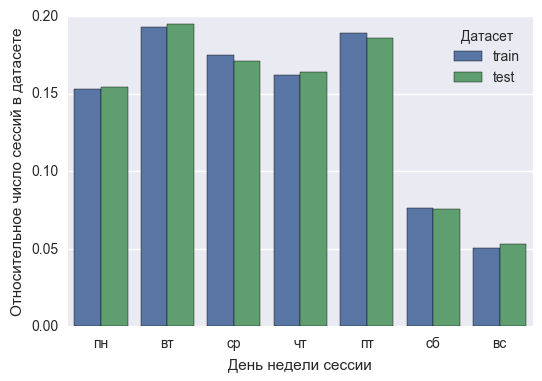

In [15]:
plot_day_of_week()

Распределения сессий по дням недели в тренировочном и тестовом датасетах также очень похожи, почти не отличаются. Больше всего сессий начинается во вторник и пятницу.

### 20 самых популярных сайтов

#### Код подготовки данных

In [16]:
data_sites = pd.DataFrame({'train': (pd.Series(df_train[cols_site].values.ravel()).value_counts() /
                           (df_train.shape[0]*10))[1:],
                           'test': (pd.Series(df_test[cols_site].values.ravel()).value_counts() /
                           (df_test.shape[0]*10))[1:]})
data_sites = data_sites[['train', 'test']]
top20_train = data_sites.sort_values(by='train', ascending=False).index[:20]
top20_test = data_sites.sort_values(by='test', ascending=False).index[:20]

Проверим, соответствует ли топ 20 сайтов train топ 20 сайтам test

In [17]:
set(top20_train) == set(top20_test)

True

#### Код графика относительного числа посещений топ-20 сайтов

In [18]:
def plot_top20_sites(data_sites):
    data_sites = data_sites.sort_values(by='train', ascending=False).iloc[:20, :]
    data_sites['site'] = [sites_dict.get(site, 'no_site') for site in data_sites.index]
    data_sites = pd.melt(data_sites, id_vars=['site'])
    ax = sns.barplot(x='site', y='value', hue='variable', data=data_sites)
    ax.legend(title="Датасет", loc="best")
    ax.set(xlabel='Сайт', ylabel='Относительное число среди\n всех сайтов в датасете')
    plt.xticks(rotation=90)
    plt.show()

### График  относительного числа посещений топ-20 сайтов

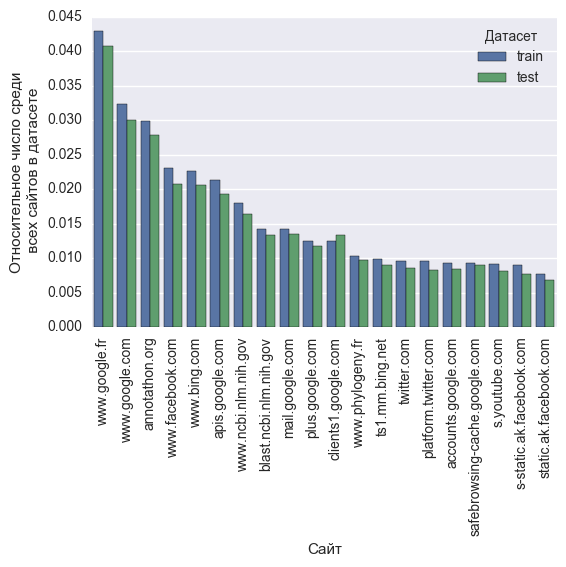

In [19]:
plot_top20_sites(data_sites)

Топ-20 самых часто посещаемых сайтов обеих датасетов совпадают (но не по порядку), и в целом частоты заходов на эти сайты похожи.

### 20 самых частых дат в сессиях

#### Код подготовки данных

In [20]:
data_dates = pd.DataFrame({'train': df_train.time1.dt.date.astype(str).value_counts() / df_train.shape[0],
                           'test': df_test.time1.dt.date.astype(str).value_counts() / df_test.shape[0]})
data_dates = data_dates[['train', 'test']]
top20_train = data_dates.sort_values(by='train', ascending=False).index[:30]
top20_test = data_dates.sort_values(by='test', ascending=False).index[:30]

Проверим, соответствует ли топ 20 сайтов train топ 20 сайтам test

In [21]:
set(top20_train) == set(top20_test)

False

Топ-20 популярных дней для train и test отличаются, построим график для топ-20 популярных дней train

#### Код графика относительного числа топ-20 дней

In [22]:
def plot_top20_sites(data_dates):
    data_dates = data_dates.sort_values(by='train', ascending=False)
    data_dates['day'] = data_dates.index
    data_dates = pd.melt(data_dates.iloc[:20,:], id_vars=['day'])
    ax = sns.barplot(x='day', y='value', hue='variable', data=data_dates)
    ax.legend(title="Датасет", loc="best")
    ax.set(xlabel='День', ylabel='Относительное число среди\n всех дней в датасете')
    plt.xticks(rotation=90)
    plt.show()

### График  относительного числа топ-20 дней

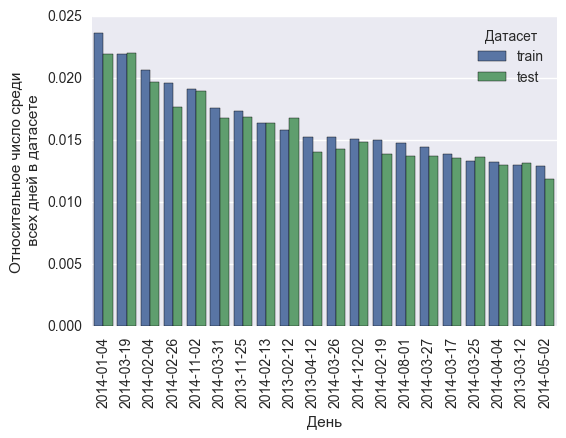

In [23]:
plot_top20_sites(data_dates)

Хоть топ-20 среди самых популярных дней и отличаются, в целом же частоты похожи. Т.е. сессии в test взяты из тех же дней, что и сессии train.

### График сессий пользователя в координатах день недели - час

Составим для каждого пользователя матрицу 17х7 (7-23ч на 7 дней недели) в каждой ячейке которой будет относительное количество сессий пользователя в этот час и этот день:

#### Код подготовки данных

In [24]:
user_matrices = {}
for user in us_dict:
    # добавим таблицу час - день недели начала сессии для каждого юзера
    z = df_train[df_train.user_id == user].pivot_table(values='user_id', index='start_hour',
                                                       columns='day_of_week', aggfunc=np.count_nonzero)
    zero_df = pd.DataFrame(np.zeros((17, 7)), columns=np.arange(7), index=np.arange(7, 24))
    z = zero_df.add(z, fill_value=0).values
    z = z / z.sum()
    user_matrices[user] = z

#### Код графика паттернов топ-10 пользователей

In [25]:
# соберем топ-10 пользователей по количеству сессий
top10_users = [us_dict_inv[i] for i in range(1, 11)]
data = [go.Heatmap(z=user_matrices[user],
                         x=['пн', 'вт', 'ср', 'чт', 'пт', 'сб', 'вс'],
                         y=np.arange(7, 24),
                         colorbar=go.ColorBar(title='Частота'),
                         colorscale='Pastel2',
                         name='User ' + str(user),
                         visible=False if user != 3165 else True) for user in top10_users]
drop_menus = []
for i, user in enumerate(top10_users):
    drop_menus.append(dict(args=['visible', [False]*i + [True] + [False]*(9-i)],
                           label='User ' + str(user),
                           method='restyle'))
    
layout = go.Layout(title='Сессии пользователя по дням недели и часам',
                   width=700, height=600,
                   autosize=False,
                   xaxis=dict(title='День недели'),
                   yaxis=dict(tickvals=np.arange(7, 24), title='Час'),
                   updatemenus=list([dict(x = -0.15,
                                          y = 1,
                                          yanchor = 'top',
                                          buttons = drop_menus,
                                          type='buttons')]))

fig = go.Figure(data=data, layout=layout)

### График топ-10 пользователей по дням недели и часам

Построим графики heatmap в осях день недели - час с возможностью выбора пользователя (из топ-10 по количеству сессий)

In [26]:
py.iplot(fig, filename='top10_heatmaps')

Как видно из графиков, паттерны пользователей заметно отличаются, но встречаются, конечно, и очень похожие (2824 и 2336).  
Таким образом, признаки дня недели, часа, а также признаки день_недели-час (17*7=119 признаков с применением one hot encoding) должны быть полезны в модели.

# Преобразование данных для vowpal wabbit

Приведем данные к формату vowpal wabbit

#### Код преобразования данных

Подготовка строк для записи в файл:

In [27]:
def prepare_vw(df, test_len):  
    sites_lines = ['|Sites ' + ' '.join([i for i in row if i != '0'])
                   for row in df[cols_site].values.astype('str').tolist()]
    
    dates_lines = ['|A_date ' + i + '_' + h for i, h in zip(df['time1'].dt.date.apply(str),
                                                            df.start_hour.astype(str))]
    day_lines = ['|Day ' + i for i in (df.day_of_week + 1).astype(str)]
    hour_lines = ['|Hour ' + i for i in df.start_hour.astype(str)]
    weekend_lines = ['|Weekend ' + (i if i == '1' else '') for i in (df.is_weekend).astype(str)]
    
    unique_lines = ['|Unique ' + i for i in (df.unique_sites).astype(str)]
    rel_unique_lines = ['|unique_rel val:' + i for i in (df.unique_sites_rel).astype(str)]
    
    length_lines = ['|Length len:' + i for i in df.session_timespan.astype('str')]
    length_lines_log = ['|length_log len:' + str(np.log(i) if i > 0 else -1) for i in df.session_timespan]
    
    diff_lines = ['|diff mean:' + mean + ' med:' + med + ' std:' + std
                  for mean, med, std in zip(df.diff_mean.astype(str),
                                            df.diff_median.astype(str),
                                            df.diff_std.astype(str))]

    all_lines = [' '.join(feats) for feats in zip(sites_lines, dates_lines,
                                                  day_lines, hour_lines, weekend_lines,
                                                  unique_lines, rel_unique_lines,
                                                  length_lines, length_lines_log, diff_lines)]
    train_lines = all_lines[:-test_len]
    test_lines = all_lines[-test_len:]
    
    return train_lines, test_lines

Запись train и test датасетов для vowpal wabbit в файлы:

In [28]:
def write_vw(train_lines, test_lines, y_all, name_train, name_test):
    with open(name_test, 'w') as f:
        f.writelines([' ' + line + '\n' for line in test_lines])

    train_lines = [y + ' ' + line + '\n'
                   for y, line in zip(y_all.astype(str).tolist(), train_lines)]
    np.random.shuffle(train_lines)

    with open(name_train, 'w') as f:
        f.writelines(train_lines)

### Результат пребразования

Пример строки из датасета train (test отличается только отсутствием label в начале:

`430 |Sites 12659 3 101 584 511 11 12659 12659 41 32 |A_date 2014-01-25_9 |Day 6 |Hour 9 |Weekend 1 |Unique 8 |unique_rel val:0.8 |Length len:3 |length_log len:1.09861228867 |diff mean:0.333333333333 med:0.0 std:0.5`

# Выбор ширины окна

Подготовим train и valid датасеты для разной ширины окна сессии

In [30]:
%%time
!mkdir valid
for i in range(1, 11):
    # загрузим pandas датафреймы для нужной ширины окна
    df, test_len = prepare_df(pre_file='pre_datasets/train_w' + str(i) + '.pkl', valid=True)
    y_all = df.user_id.apply(lambda x: us_dict.get(x, -1))
    # сохраним ответы для валидационного датасета
    y_true = y_all[-test_len:]
    with open('valid/y_true_w' + str(i) + '.pkl', 'wb') as f:
        pickle.dump(y_true, f)
    # подготовим и запишем датасеты в формате vw
    train_lines, test_lines = prepare_vw(df, test_len)
    write_vw(train_lines, test_lines, y_all, 'valid/train_w' + str(i), 'valid/valid_w' + str(i))
    print('Datasets for window {} done'.format(i))

Datasets for window 1 done
Datasets for window 2 done
Datasets for window 3 done
Datasets for window 4 done
Datasets for window 5 done
Datasets for window 6 done
Datasets for window 7 done
Datasets for window 8 done
Datasets for window 9 done
Datasets for window 10 done
CPU times: user 5min 14s, sys: 4.62 s, total: 5min 18s
Wall time: 5min 24s


Посмотрим, какая точность получится при каждой ширине окна на признаках посещенных сайтов

In [31]:
%%time
window_scores = []
for i in range(1, 11):
    train = 'valid/train_w' + str(i)
    model = 'valid/model_w' + str(i)
    valid = 'valid/valid_w' + str(i)
    pred = 'valid/pred_w' + str(i)
    feats = '--keep S'
    
    !vw --oaa 550 --passes $i -d $train -f $model -c -k -b 29 \
    --quiet --holdout_off --random_seed 19 \
    --loss_function hinge $feats
    
    !vw -i $model -t -d $valid -p $pred $feats --quiet
    
    pred = np.loadtxt(pred, dtype=int)
    with open('valid/y_true_w' + str(i) + '.pkl', 'rb') as f:
        y_true = pickle.load(f)
    score = accuracy_score(pred, y_true.values)
    window_scores.append((i, score))
    print('Window {0} accuracy: {1:.6f}'.format(i, score)) 

Window 1 accuracy: 0.469875
Window 2 accuracy: 0.451166
Window 3 accuracy: 0.437414
Window 4 accuracy: 0.428769
Window 5 accuracy: 0.405439
Window 6 accuracy: 0.389237
Window 7 accuracy: 0.378678
Window 8 accuracy: 0.353039
Window 9 accuracy: 0.340647
Window 10 accuracy: 0.317531
CPU times: user 19.6 s, sys: 1.18 s, total: 20.8 s
Wall time: 4min 58s


Как видно, чем меньше окно, тем лучше результат. Но это скорее всего объясняется тем, что данных при этом больше, и сессии больше совпадают. На практике при отправке предсказаний для тестового датасета на kaggle, такого результата не было, и я впоследствии остановился посередине - на окне 5.

# Отбор признаков, добавление взаимодействий признаков

Vowpal wabbit позволяет с помощью аргументов командной строки и первой буквы namespace признаков управлять тем, какие признаки использовать, какие игнорировать, и какие взаимодействия между ними включать в модель:
- --keep arg - какие признаки оставить в модели, остальные игнорируются
- --ignore arg - какие признаки игнорировать, остальные остаются
- --interactions - какие взаимодействия между признаками включить в модель, для любого кол-ва признаков (а также -q для двух и --cubic для трех)

#### Код функций для отбора

In [32]:
def vw_predict(keep, ignore, interactions, window=10, passes=3,
               model='tmp/model_tmp', pred='tmp/pred'):
    train = 'valid/train_w' + str(window)
    valid = 'valid/valid_w' + str(window)
    if keep:
        keep = '--keep ' + keep
    if interactions:
        interactions = '--interactions ' + interactions
    if ignore:
        ignore = '--ignore ' + ignore
    feats = ' '.join([i for i in [keep, ignore, interactions] if i])
    
    !vw --oaa 550 --passes $passes -d $train -f $model -c -k -b 29 \
    --quiet --holdout_off --random_seed 19 \
    --loss_function hinge $feats
    
    !vw -i $model -t -d $valid -p $pred $feats --quiet
    
    pred = np.loadtxt(pred, dtype=int)
    with open('valid/y_true_w' + str(window) + '.pkl', 'rb') as f:
        y_true = pickle.load(f)
    score = accuracy_score(pred, y_true.values)
    return score

In [33]:
all_features = 'SDHAWUuLld'

In [34]:
def feature_select():
    features = all_features
    basic_score = vw_predict(features, '', '')
    print('basic score:', '{} {}'.format(features, basic_score), '*' * 80, sep='\n')
    while True:
        feat_dict = {}
        for feat in features:
            new_features = ''.join(set(features) - {feat})
            score = vw_predict('', feat, '')
            feat_dict[new_features] = score
            print('--keep', new_features, '--ignore', feat, score)
        max_feats_score = sorted(feat_dict.items(), key=lambda x: -x[1])[0]
        if max_feats_score[1] > basic_score:
            features = max_feats_score[0]
            basic_score = max_feats_score[1]
            print('*' * 80, 'new basic score:', '{} {}'.format(features, basic_score), '*' * 80, sep='\n')
        else:
            break
    print('*' * 80)
    print('Final features: ', features)
    print('Final score: ', basic_score)

### Выполнение отбора

Проверим, включение каких признаков ухудшает модель на датасете с окном 10:

In [35]:
feature_select()

basic score:
SDHAWUuLld 0.5501520884338601
********************************************************************************
--keep DlLUHWdAu --ignore S 0.298204614586
--keep lLUHWdASu --ignore D 0.546628088137
--keep DlLUWdASu --ignore H 0.545960382818
--keep DlLUHWdSu --ignore A 0.390496327621
--keep DlLUHdASu --ignore W 0.549781141034
--keep DlLHWdASu --ignore U 0.544624972179
--keep DlLUHWdAS --ignore u 0.551264930633
--keep DlUHWdASu --ignore L 0.549002151495
--keep DLUHWdASu --ignore l 0.550411751614
--keep DlLUHWASu --ignore d 0.549076340975
********************************************************************************
new basic score:
DlLUHWdAS 0.5512649306328362
********************************************************************************
--keep lLUHWdAS --ignore D 0.546628088137
--keep DLUHWdAS --ignore l 0.550411751614
--keep DlUHWdAS --ignore L 0.549002151495
--keep DlLHWdAS --ignore U 0.544624972179
--keep DlLUWdAS --ignore H 0.545960382818
--keep DlLUHdAS --ignore W 0

Видимо, лучше игнорировать относительное количество уникальных сайтов в сессии, но разница при этом незначительная и скорее всего это случайный результат, т.к. при этом же используются признаки и логарифма длины сессии, и длины в секундах.

Далее можно поперебирать все взаимодействия между признаками и добавлять их к модели, но это очень долго и не нужно (хотя, можно попробовать на меньшем числе пользователей). Если посмотреть на отбор признаков, то можно заметить, что самые большие проседания в accuracy были при игнорировании таких признаков, как:
- S - посещенные сайты
- A - дата сессии до часа (например, 2014-01-25_9)

А также при визуальном анализе выяснилось, что пользователи достаточно отличаются по поведению в разные дни недели и часы:
- D - день недели сессии
- H - час сессии

Посмотрим, как добавление взаимодействий между этими признаками повлияет на точность:

In [37]:
%%time
features = 'HADUWSdlu'
basic_score = vw_predict(features, '', '')
print('basic score:', '{} {}'.format(features, basic_score), '*' * 80, sep='\n')
for interact in ['SA', 'DH', 'SAD', 'SAH', 'SADH']:
    print('--interact ' + interact, vw_predict(features, '', interact))

basic score:
HADUWSdlu 0.549002151494918
********************************************************************************
--interact SA 0.617738704652
--interact DH 0.550893983233
--interact SAD 0.618517694191
--interact SAH 0.617961273091
--interact SADH 0.618109652051
CPU times: user 6.58 s, sys: 668 ms, total: 7.25 s
Wall time: 2min 28s


Похоже, что лучше всего на модели сказывается добавление взаимодействий между признаками посещенных сайтов, даты сессии и дня недели (возможно, еще и часа, результаты при этом не сильно отличаются). Это логично, т.к. сессии для train и test взяты из одних дней, а в конкретный день конкретный юзер скорее всего посещал определенные сайты и каждый сайт, скорее всего не по одному разу.

# Финальная модель

Сделаем предсказание для тестового датасета на основе:
- все данные train с шириной окна 5 (установлено опытным путем при отправке на kaggle)
- все признаки
- добавление взаимодействий между признаками посещенных сайтов (S), даты сессии (A), часа (H) и дня недели (D)
- функция потерь logistic (установлено позднее опытным путем), но при ней модель обучается в разы дольше, чем при использовании hinge

In [38]:
%%time
# загрузим pandas датафреймы для нужной ширины окна
df, test_len = prepare_df(pre_file='pre_datasets/train_w5.pkl', valid=False)
y_all = df.user_id.apply(lambda x: us_dict.get(x, -1))

# подготовим и запишем датасеты в формате vw
train_lines, test_lines = prepare_vw(df, test_len)
write_vw(train_lines, test_lines, y_all, 'tmp/train_w5', 'tmp/test_w5')

# обучение модели
!vw --oaa 550 --passes 4 -d tmp/train_w5 -f tmp/model -c -k -b 29 \
--holdout_off --random_seed 19 \
--loss_function logistic --interactions SADH

# построение предсказаний
!vw -i tmp/model -t -d tmp/test_w5 -p tmp/pred_w5 --interactions SADH --quiet

creating features for following interactions: SADH 
final_regressor = tmp/model
Num weight bits = 29
learning rate = 0.5
initial_t = 0
power_t = 0.5
decay_learning_rate = 1
creating cache_file = tmp/train_w5.cache
Reading datafile = tmp/train_w5
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
1.000000 1.000000            1            1.0      317        1       29
1.000000 1.000000            2            2.0       42      317       30
1.000000 1.000000            4            4.0        5      423       31
1.000000 1.000000            8            8.0      143        5       31
1.000000 1.000000           16           16.0       38      423       31
1.000000 1.000000           32           32.0        6      198       31
0.968750 0.937500           64           64.0      134        1       31
0.960938 0.953125          128          128.0      214        3       31
0.929688

In [40]:
# сохранить для отправки на kaggle
pred = np.loadtxt('tmp/pred_w5', dtype=int)
pd.DataFrame(np.vstack((np.arange(1, len(pred)+1), [us_dict_inv[i] for i in pred])).T,
             index=None, columns=['session_id', 'user_id']).to_csv('pred_final.csv', index=None)

Эта модель на public leaderboard получила **0.66694**

Ради интереса посмотрим, сколько получит модель только с признаками сайтов, дат и их взаимодействия

In [42]:
# обучение модели
!vw --oaa 550 --passes 4 -d tmp/train_w5 -f tmp/model -c -k -b 29 \
--holdout_off --random_seed 19 \
--loss_function logistic --keep SA --interactions SA --quiet

# построение предсказаний
!vw -i tmp/model -t -d tmp/test_w5 -p tmp/pred_w5_2 --keep SA --interactions SA --quiet

# сохранить для отправки на kaggle
pred = np.loadtxt('tmp/pred_w5_2', dtype=int)
pd.DataFrame(np.vstack((np.arange(1, len(pred)+1), [us_dict_inv[i] for i in pred])).T,
             index=None, columns=['session_id', 'user_id']).to_csv('pred_final_2.csv', index=None)

И, как ни странно, данная модель показала результат **0.66621**, практически не отличающийся от предыдущего

Настройка параметров learning_rate, initial_t, power_t позволила повысить итоговый результат до **0.67777**

# Выводы

- Определяющими признаками являются посещенные сайты, дата сессии с точностью до часа и взаимодействие этих признаков - использование только их в vowpal wabbit позволяет достичь точности 0.666, все остальные незначительно повышают качество модели


- Во время подготовки проекта также были опробованы признаки доменов разных уровней, их tfidf, tfidf сайтов, включая n-граммы (можно добавить в vowpal wabbit в командной строке), но результата они не принесли


- Также были испробованы различные параметры vowpal wabbit, которые не принесли результата:  
 - --csoaa - Cost Sensitive One Against All - oaa c определением cost для каждого класса
 - --log_multi - online (decision) trees for classes (in log(arg) time)
 - --recall_tree - тоже реализация онлайн деревьев

Что еще хотелось бы попробовать:
- подбор параметров vowpal wabbit с hyperopt
- xgboost
- блендинг моделей

Применимость на практике:
- данная модель должна неплохо (учитывая количество классов) размечать уже имеющиеся логи - какому пользователю какой принадлежит, но на логах с датами, которых нет в тренировочном датасете, она будет работать хуже. При этом все же можно неплохо проследить за поведением пользователей (куда, когда и как часто заходят).

Ну и как итог, я очень доволен данным проектом, во время его выполнения я не только освежил многое изученное в специализации, но и попрактиковался в vowpal wabbit, в визуализациях с помощью разных пакетов (в частности, plotly), виджетах и экстеншнах jupyter.